In [1]:
!pip install pydub
!pip install fastaudio
# If you are using Colab, restart your notebook after running this cell.

# Scraping Xeno-Canto API

In [2]:
import pandas as pd
import requests
from tqdm import tqdm

country = 'brazil'
response = requests.get(f'https://www.xeno-canto.org/api/2/recordings?query=cnt:{country}')
js = response.json()

df = pd.DataFrame()
for n_page in tqdm(range(1, js["numPages"]+1)):
    response = requests.get(f'https://www.xeno-canto.org/api/2/recordings?query=cnt:{country}&page={n_page}')
    page_json = response.json()
    ids, files, file_names, ens, lengths, gens = [], [], [], [], [], []
    for recording in page_json["recordings"]:
        ids.append(recording["id"])
        files.append(recording["file"])
        file_names.append(recording["file-name"])
        ens.append(recording["en"])
        lengths.append(recording["length"])
        gens.append(recording["gen"])


    df_ = pd.DataFrame.from_records({'id': ids, "file": files, "file-name": file_names, "en": ens, "gen": gens, "length": lengths})
    df = df.append(df_)
    
df.to_csv("birds.csv", index=False)

100%|██████████| 118/118 [03:30<00:00,  1.78s/it]


#Downloading selected files

In [3]:
from pandas import read_csv
from urllib.request import urlretrieve
from os import listdir, mkdir, path as os_path
from tqdm.notebook import tqdm
from time import sleep

df = read_csv("birds.csv")

#Removing recordings that are not classified
df = df[df['en'] != 'Identity unknown'].copy()
df = df[df['en'] != 'Soundscape'].copy()
#Choosing the 10 most common species
counts = df['en'].value_counts()
chosen = counts.head(10).index
df = df[df["en"].isin(chosen)]
df.to_csv("to_download.csv", index=False)

print(df.shape)
print(len(df["en"].unique()), "different species")

audio_dir = 'audio_files/'
if not os_path.isdir(audio_dir):
    mkdir(audio_dir)

nots = []

for row in tqdm(df.iterrows(), total=df.shape[0]):
    url = row[1]["file"]
    f_name = str(row[1]["id"]) + row[1]["file-name"][-4:].lower()
    try:
        urlretrieve('https:'+url, filename=audio_dir + f_name)
    except Exception as e:
        print("\nRetrying:", url)
        print(e) 
        sleep(60)
        try:
            urlretrieve('https:'+url, filename=audio_dir + f_name)
        except Exception as ee:
            print("Not downloaded|", f_name)
            print(ee)
            nots.append(row[1]["id"])
            pass

if len(nots) > 0:
    with open('not_downloaded.txt', 'w') as f:
        for item in nots:
            f.write(str(item) + '\n')
    print(str(nots))
else:
    print('All files were successfully downloaded!')

(2145, 6)
10 different species


  0%|          | 0/2145 [00:00<?, ?it/s]

All files were successfully downloaded!


# Preprocess audio files and split data

In [4]:
from os import listdir, mkdir, path as os_path
from sklearn.model_selection import train_test_split
from pydub import AudioSegment
from os import listdir, mkdir
import pandas as pd
from tqdm.notebook import tqdm

data_dir = './'
df = pd.read_csv(data_dir+'to_download.csv')

audio_dir = data_dir+'audio_files/'
downloaded_files = listdir(audio_dir)
#Check downloaded files
df['file-name'] = df['file-name'].str.lower()
df['filename'] = df['id'].astype(str) + df['file-name'].str[-4:]
downloaded = df[df['filename'].isin(downloaded_files)][['filename', 'en']]
downloaded.to_csv('downloaded.csv', index=False)
# print('Not downloaded:', len(df) - len(downloaded))

train, test = train_test_split(downloaded[['filename', 'en']], stratify=downloaded["en"], test_size=0.1)

def to_wav(filename, n_channels, sample_rate, input_dir, output_dir):
    input_type = filename[-4:].lower()
    if input_type == '.mp3':
        sound = AudioSegment.from_mp3(f"{input_dir}/{filename}")
        new_fn = fn[:-4] + '.wav'
    elif input_type == '.wav':
        sound = AudioSegment.from_wav(f"{input_dir}/{filename}")
        new_fn = filename
    sound = sound.set_channels(n_channels)
    sound.set_frame_rate(sample_rate)
    sound.export(f"{output_dir}/{new_fn}", format="wav")

wav_dir = data_dir+'wav_files/'
if not os_path.isdir(wav_dir):
    mkdir(wav_dir)
    mkdir(wav_dir + 'test/')
    mkdir(wav_dir + 'train/')

In [ ]:
for fn in tqdm(test['filename']):
    to_wav(fn, n_channels=1, sample_rate=16000, input_dir=audio_dir, output_dir=wav_dir+'test')

for fn in tqdm(train['filename']):
    to_wav(fn, n_channels=1, sample_rate=16000, input_dir=audio_dir, output_dir=wav_dir+'train')

  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/1930 [00:00<?, ?it/s]

#Model

## Preparing dataframes

In [ ]:
from os import listdir, mkdir
import pandas as pd
wav_dir = data_dir+'wav_files/'
downloaded = pd.read_csv(data_dir+'downloaded.csv')
downloaded['filename'] = downloaded['filename'].str[:-4] + '.wav'
print(downloaded.shape)
downloaded.columns = ['filename', 'category']
train_files = listdir(wav_dir+'train')
test_files = listdir(wav_dir+'test')
df = downloaded[downloaded['filename'].isin(train_files)]
df_test = downloaded[downloaded['filename'].isin(test_files)]
print(df.shape)
print(df_test.shape)

(2145, 2)
(1930, 2)
(215, 2)


## Transforms

In [ ]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *
from fastaudio.ci import skip_if_ci

torch.cuda.empty_cache()

path = Path('.')
seconds = 15
cfg = AudioConfig.BasicMelSpectrogram(n_fft=512)
a2s = AudioToSpec.from_cfg(cfg)
# item_transforms = [ResizeSignal(seconds*1000, pad_mode=AudioPadType.Repeat), a2s]
item_transforms = [a2s]

/usr/local/lib/python3.7/dist-packages/torchaudio/backend/utils.py:47: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  '"torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. '
/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:358: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  "At least one mel filterbank has all zero values. "


## Datablocks and dataloaders

In [ ]:
train_dir = wav_dir+'train'
auds = DataBlock(blocks = (AudioBlock(crop_signal_to=seconds*1000), CategoryBlock),
                 get_x = ColReader("filename", pref=path/train_dir), 
                 splitter = TrainTestSplitter(random_state=42, stratify=df['category'], test_size=0.2),
                 item_tfms = item_transforms,
                 get_y = ColReader("category")
                 )

In [ ]:
batch_size = 64
dbunch = auds.dataloaders(df, bs=batch_size, shuffle=False, seed=42)

In [ ]:
set_seed(42,True)
dbunch.rng.seed(42)

## Checking batch

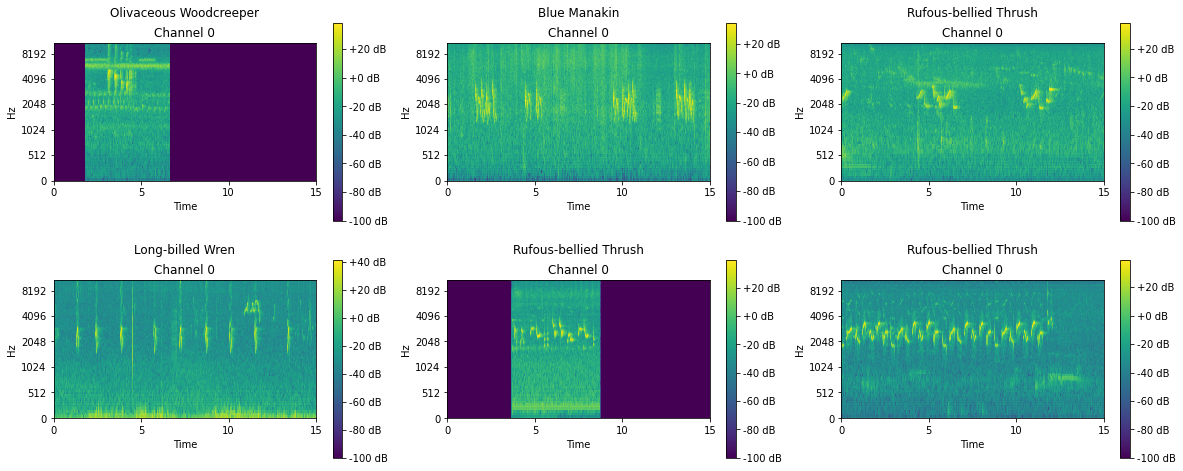

In [ ]:
dbunch.show_batch(figsize=(20, 8), nrows=2, ncols=3)

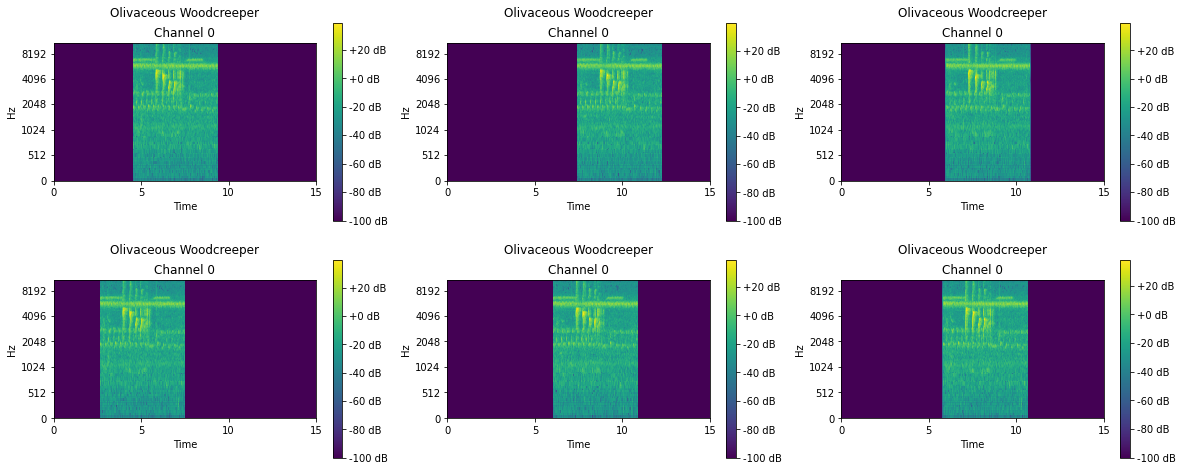

In [ ]:
dbunch.show_batch(figsize=(20, 8), nrows=2, ncols=3, unique=True)

## Instantianting model

In [ ]:
model_arch = resnet34
learn = cnn_learner(dbunch, 
            model_arch,
            n_in=1,
            loss_func=CrossEntropyLossFlat(),
            metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

##Finding optimal learning rate

0.0006918309628963471


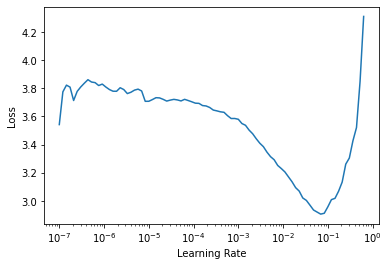

In [ ]:
lr = learn.lr_find()[0]/10
print(lr)

## Training

In [ ]:
callbacks = [SaveModelCallback(), ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=2), EarlyStoppingCallback(monitor='valid_loss', min_delta=0.05, patience=4)]
learn.fine_tune(20, wd=0.1, base_lr=lr, cbs=callbacks)

epoch,train_loss,valid_loss,accuracy,time
0,3.383358,2.065547,0.347150,02:19


Better model found at epoch 0 with valid_loss value: 2.065546989440918.


epoch,train_loss,valid_loss,accuracy,time
0,2.544793,1.897402,0.404145,02:23
1,2.357039,1.708111,0.443005,02:21
2,2.119717,1.435366,0.510363,02:21
3,1.858872,1.306574,0.616580,02:20
4,1.598369,1.081339,0.673575,02:20
5,1.353586,0.936668,0.720207,02:18
6,1.135123,0.895335,0.712435,02:19
7,0.951284,0.814880,0.735751,02:18
8,0.798196,0.763675,0.751295,02:21
9,0.691646,0.697362,0.787565,02:20


Better model found at epoch 0 with valid_loss value: 1.8974021673202515.
Better model found at epoch 1 with valid_loss value: 1.7081105709075928.
Better model found at epoch 2 with valid_loss value: 1.4353655576705933.
Better model found at epoch 3 with valid_loss value: 1.3065741062164307.
Better model found at epoch 4 with valid_loss value: 1.081338882446289.
Better model found at epoch 5 with valid_loss value: 0.9366676211357117.
Better model found at epoch 6 with valid_loss value: 0.8953346610069275.
Better model found at epoch 7 with valid_loss value: 0.8148803114891052.
Better model found at epoch 8 with valid_loss value: 0.7636747360229492.
Better model found at epoch 9 with valid_loss value: 0.6973622441291809.
Better model found at epoch 10 with valid_loss value: 0.6809508800506592.
Epoch 11: reducing lr to 2.129577756742047e-05
Epoch 13: reducing lr to 1.3598818311020207e-05
No improvement since epoch 9: early stopping


In [ ]:
## Save results
# learn.save('model0')

## Checking results

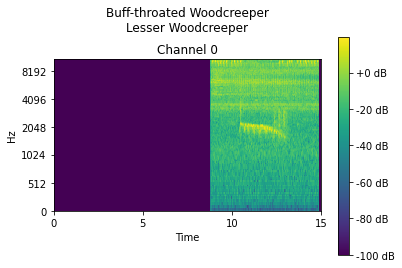

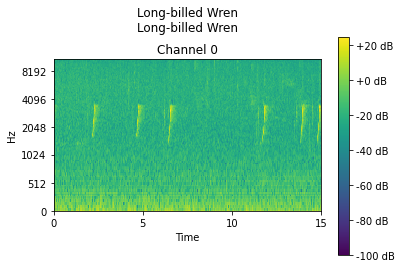

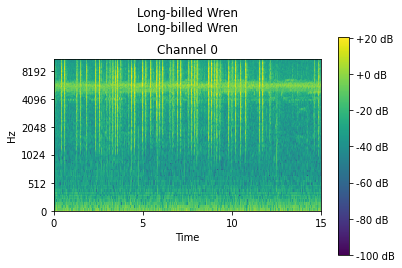

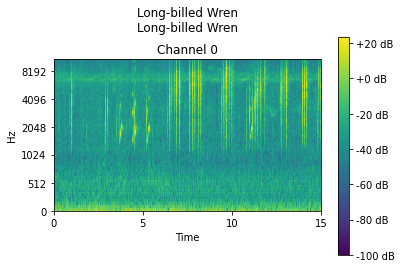

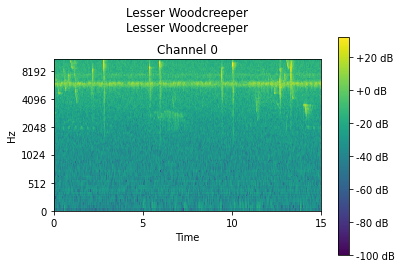

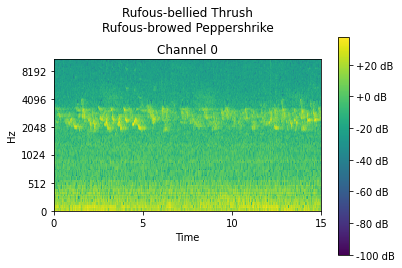

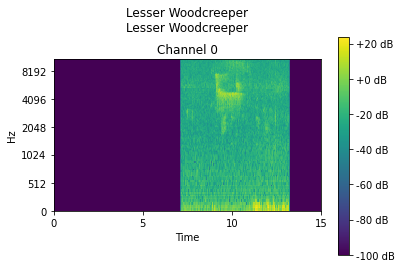

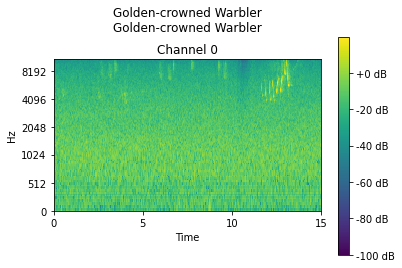

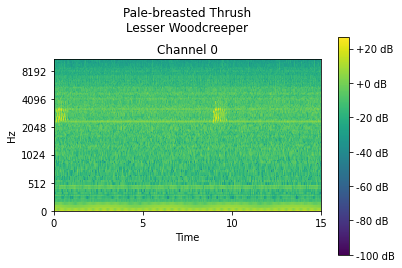

In [ ]:
learn.show_results()

[('Pale-breasted Thrush', 'Rufous-bellied Thrush', 8),
 ('Olivaceous Woodcreeper', 'Lesser Woodcreeper', 5),
 ('Yellow-olive Flatbill', 'Golden-crowned Warbler', 5),
 ('Olivaceous Woodcreeper', 'Yellow-olive Flatbill', 4),
 ('Long-billed Wren', 'Blue Manakin', 3),
 ('Pale-breasted Thrush', 'Yellow-olive Flatbill', 3),
 ('Blue Manakin', 'Buff-throated Woodcreeper', 2),
 ('Lesser Woodcreeper', 'Golden-crowned Warbler', 2),
 ('Long-billed Wren', 'Buff-throated Woodcreeper', 2),
 ('Long-billed Wren', 'Olivaceous Woodcreeper', 2)]

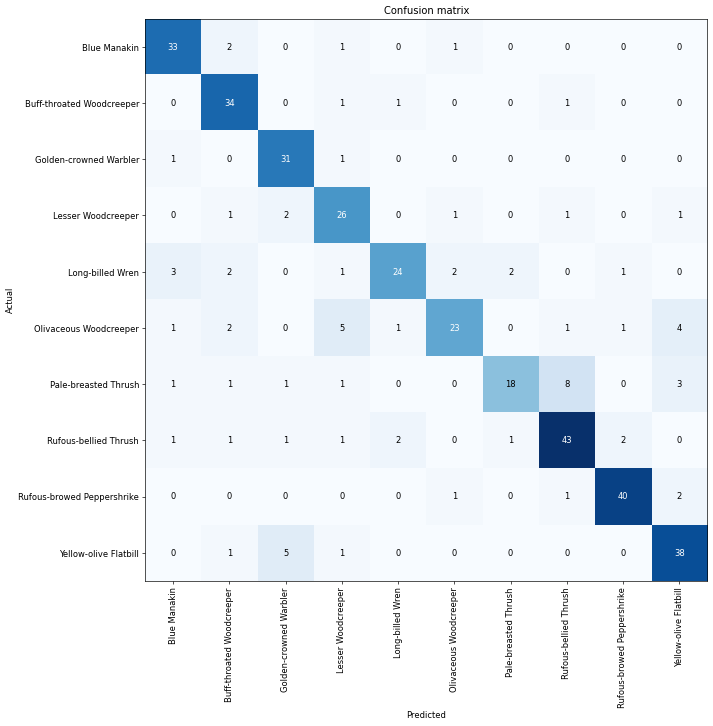

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
interp.most_confused()[:10]

## Testing model on new data

In [ ]:
test_dir = wav_dir+'test'
auds_test = DataBlock(blocks = (AudioBlock(crop_signal_to=seconds*1000), CategoryBlock),  
                 get_x = ColReader("filename", pref=path/test_dir),
                 item_tfms = item_transforms,
                 get_y = ColReader("category")
                 )

dbunch_test = auds_test.dataloaders(df_test, bs=batch_size, shuffle=False, seed=42)

In [ ]:
learn = cnn_learner(dbunch_test, 
            model_arch,
            n_in=1,
            loss_func=CrossEntropyLossFlat(),
            metrics=[accuracy])
learn.load('model')
dbunch_test.rng.seed(42)
set_seed(42,True)

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [ ]:
learn.data = dbunch_test
preds1, y = learn.get_preds(dl=dbunch_test[0])
acc1 = accuracy(preds1, y)

[('Olivaceous Woodcreeper', 'Lesser Woodcreeper', 3),
 ('Pale-breasted Thrush', 'Rufous-bellied Thrush', 3),
 ('Golden-crowned Warbler', 'Buff-throated Woodcreeper', 1),
 ('Lesser Woodcreeper', 'Olivaceous Woodcreeper', 1),
 ('Lesser Woodcreeper', 'Yellow-olive Flatbill', 1),
 ('Long-billed Wren', 'Buff-throated Woodcreeper', 1),
 ('Long-billed Wren', 'Olivaceous Woodcreeper', 1),
 ('Olivaceous Woodcreeper', 'Rufous-bellied Thrush', 1),
 ('Pale-breasted Thrush', 'Lesser Woodcreeper', 1),
 ('Pale-breasted Thrush', 'Long-billed Wren', 1)]

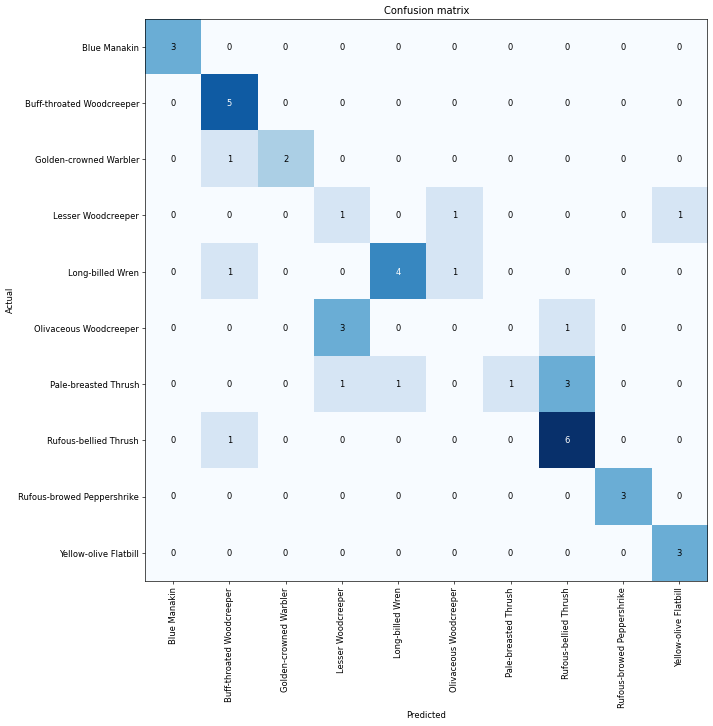

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
interp.most_confused()[:10]

In [ ]:
learn.data = dbunch_test
preds2, y = learn.get_preds(dl=dbunch_test[1])
acc2 = accuracy(preds2, y)

[('Pale-breasted Thrush', 'Rufous-bellied Thrush', 4),
 ('Olivaceous Woodcreeper', 'Lesser Woodcreeper', 2),
 ('Buff-throated Woodcreeper', 'Rufous-bellied Thrush', 1),
 ('Lesser Woodcreeper', 'Buff-throated Woodcreeper', 1),
 ('Lesser Woodcreeper', 'Olivaceous Woodcreeper', 1),
 ('Long-billed Wren', 'Blue Manakin', 1),
 ('Long-billed Wren', 'Buff-throated Woodcreeper', 1),
 ('Long-billed Wren', 'Rufous-browed Peppershrike', 1),
 ('Olivaceous Woodcreeper', 'Buff-throated Woodcreeper', 1),
 ('Olivaceous Woodcreeper', 'Rufous-bellied Thrush', 1)]

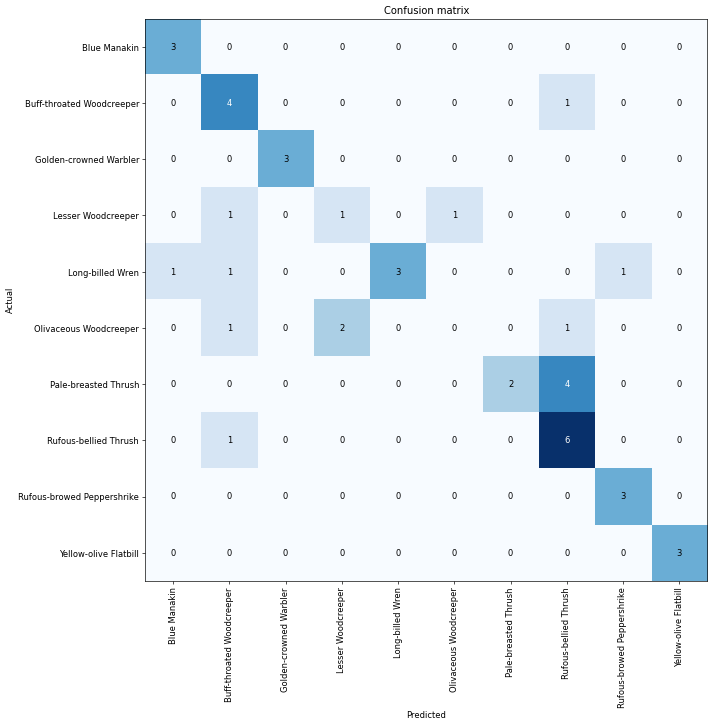

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
interp.most_confused()[:10]

In [ ]:
preds1.shape[0] + preds2.shape[0]

215

In [ ]:
(acc1*preds1.shape[0] + acc2*preds2.shape[0])/(preds1.shape[0] + preds2.shape[0])

TensorBase(0.7442)